# Predicting Bike Demand for Bike Sharing in Washington D.C.
## Utilization of Different Statistical Models to Reduce the Cost Function for Bike Sharing Demand

Source: Hadi Fanaee-T  
Institution: University of Porto  
Link: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset  

#### This analysis will show the effectiveness of different statistical models in this bike sharing data set. The goal is to minimize the cost function as much as possible. The model produced should be able to reasonably predict the correct demand for bikes at any point in time, given the conditions presented. The predicted demand for bikes should theoretically give the bike sharing operator the reasonable number of bikes that should be available on Washington D.C.'s streets.

In [1]:
# Import the necessary libraries to open and analyze the dataset.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Open the dataset as a Pandas DataFrame called 'bike'.
bike = pd.read_csv('hour.csv')
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Here's the quick description of the columns in the dataset:

1. instant - This provides a number for the individual observations in the dataset. Each 'instant' is equivalent to an hour.
2. dteday - This shows the date for each observation.
3. season - This column segregates the following observations per season. According to the source of the dataset, these are the following meanings of the numbers: 1 = winter, 2 = spring, 3 = summer, 4 = fall.
4. yr - This shows the year when each observation was recorded. The source gives a translation for the numbers: 0 = 2011, 1 = 2012.
5. mnth - This is the month of the observation. Numbers in the column correspond to the order of the months (1 = January, 6 = June, etc.).
6. hr - Hour of the day in 24:00 format.
7. holiday - This translates if the day of observation is a holiday or not.
8. weekday - The day of the week.
9. workingday - This shows the day if people go to work (i.e. not a holiday or weekend). According to the source, value is at 1 if people are at work, otherwise 0.
10. weathersit - Shows the weather conditions in through numbers 1 to 4, with 1 being the best weather condition and 4 being the worst.
11. temp - Normalized temperature in Celsius. Normalization happens when all of the values in a column is converted to values between 0 and 1.
12. atemp - Normalized feeling temperature in Celsius.
13. hum - Normalized humidity.
14. windspeed - Normalized wind speed.
15. casual - Number of users who do not have an existing membership.
16. registered - Number of users who have a membership.
17. cnt - Total count of users renting a bike at a certain hour or observation.

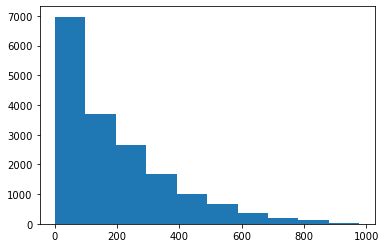

(0.023, 98.6]     0.401174
(98.6, 196.2]     0.213188
(196.2, 293.8]    0.153001
(293.8, 391.4]    0.095518
(391.4, 489.0]    0.057368
(489.0, 586.6]    0.037574
(586.6, 684.2]    0.021233
(684.2, 781.8]    0.010818
(781.8, 879.4]    0.007998
(879.4, 977.0]    0.002129
Name: cnt, dtype: float64

In [3]:
# Determine the distribution of bike demand per hour.
plt.hist(bike['cnt'])
plt.show()
bike['cnt'].value_counts(bins=10, normalize=True)

The data shows that for 40% of observations conducted, less than 100 bikes are rented. Observations conducted from night time to early morning could have contributed to this.

Let's see the correlation of the total bikes rented ('cnt') to the other columns.

In [4]:
# See the correlations of the following columns with the total number of bikes rented ('cnt').
bike.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

The data shows that strongest correlations for bike rentals are temperature, humidity, and hour of the day. Note that the casual and registered columns should not be included since they are used to count the total bikes rented.

We can segregate the hours depending on the time of day such as morning, afternoon, evening, and early morning. We can assign numbers to these for their upcoming usage in statistical models.

In [5]:
# Create a function to segregate the hours to time of day.
def assign_label(num):
    if (num >= 6) and (num < 12):
        return 1
    elif (num >= 12) and (num < 18):
        return 2
    elif (num >= 18) and (num < 24):
        return 3
    elif (num == 24) or ((num >= 0) and (num < 6)):
        return 4

In [6]:
# Insert the function through the apply method.
bike['time_label'] = bike['hr'].apply(assign_label)

Let's create a heatmap to easily see the correlation of the columns with one another. We can also check what columns to use as features for the initial part of our analysis.

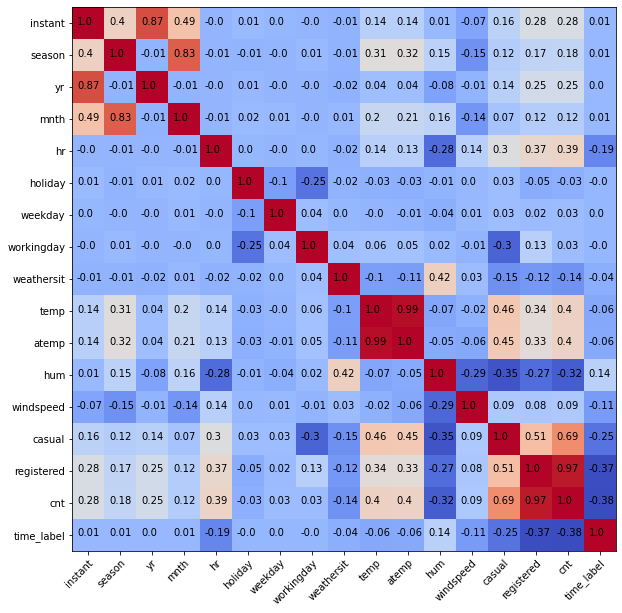

In [7]:
# Create a heatmap with the existing columns.
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(bike.corr(), cmap='coolwarm')
column_list = bike.columns.tolist()
column_list.remove('dteday')
ax.set_xticks(np.arange(len(column_list)), labels=column_list)
plt.setp(ax.get_xticklabels(), rotation_mode="anchor", ha="right", rotation=45)
ax.set_yticks(np.arange(len(column_list)), labels=column_list)
for row in column_list:
    for col in column_list:
        ax.text(s=round(bike.corr()[row][col],2), x=column_list.index(row)-0.35, y=column_list.index(col)+0.05)
plt.show()

To prevent collinearity:
1. 'temp' and 'atemp' should not be used together. Can use any one of the choices since correlation with 'cnt' is the same (0.4).
2. 'season' and 'mnth' should not be used together. If needed to choose one, it is recommended to use 'season' since it has higher correlation with 'cnt' (0.18).

NOTE: For obvious reasons, 'casual' and 'registered' should not be used since they can be used to add up to predict 'cnt'. This will make the analysis useless. 'instant' is also not useful for the study since it just counts the amount of observations.

Recommended features to use due to correlation with 'cnt':
1. 'time_label'
2. 'hum'
3. 'atemp'
4. 'hour'
5. 'season'

In [8]:
# Create a list for the features we are going to use for our statistical models.
feature_columns = ['time_label', 'hum', 'atemp', 'hr', 'season']

In [9]:
# Randomize the dataset to ensure accuracy of statistical models.
np.random.seed(1)
bike = bike.reindex(np.random.permutation(bike.index))

# Create cutoff value to separate train and test dataset. Train dataset to take 80% of total dataset rows. Test dataset to take the remaining 20%.
cutoff = round(bike.shape[0]*0.80)
train = bike.iloc[:cutoff, :]
test = bike.iloc[cutoff:, :]

Linear regression will be used for the first model. If the values generated are not significant or acceptable for actual applications, we can proceed with more complex models.

## Linear Regression Model

In [10]:
# Import LinearRegression and mean_squared_error for the first attempt to generate a statistical model.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Use LinearRegression for the first model and RMSE to see the accuracy of the model.
lr = LinearRegression()
lr.fit(train[feature_columns], train['cnt'])
train_predictions = lr.predict(train[feature_columns])
train_rmse = mean_squared_error(train_predictions, train['cnt'], squared=False)
print('Train RMSE: {:.2f}'.format(train_rmse))
test_predictions = lr.predict(test[feature_columns])
test_rmse = mean_squared_error(test_predictions, test['cnt'], squared=False)
print('Test RMSE: {:.2f}'.format(test_rmse))

Train RMSE: 139.45
Test RMSE: 135.59


As seen from the number of bikes rented, the rmse value appears to be too high to correctly predict the bike demand at a certain period. We can improve on this by using a Decision Tree.

## Decision Tree Model

In [11]:
# Import DecisionTreeRegressor.
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regressor.
dtr = DecisionTreeRegressor()
dtr.fit(train[feature_columns], train['cnt'])
train_predictions = dtr.predict(train[feature_columns])
train_rmse = mean_squared_error(train_predictions, train['cnt'], squared=False)
print('Train RMSE: {:.2f}'.format(train_rmse))
test_predictions = dtr.predict(test[feature_columns])
test_rmse = mean_squared_error(test['cnt'], test_predictions, squared=False)
print('Test RMSE: {:.2f}'.format(test_rmse))

Train RMSE: 52.00
Test RMSE: 133.42


Test RMSE value is similar to the first model with linear regression and it appears there is overfitting. We can proceed with a more complex model, but we can first tweak the values to see if the model can lower the error and overfitting.

For this, we can tweak the parameters 'min_samples_leaf', 'min_samples_split', and 'max_depth'.  The parameters can be adjusted individually to see how the RMSE will react.

### Adjust 'min_samples_leaf' parameter

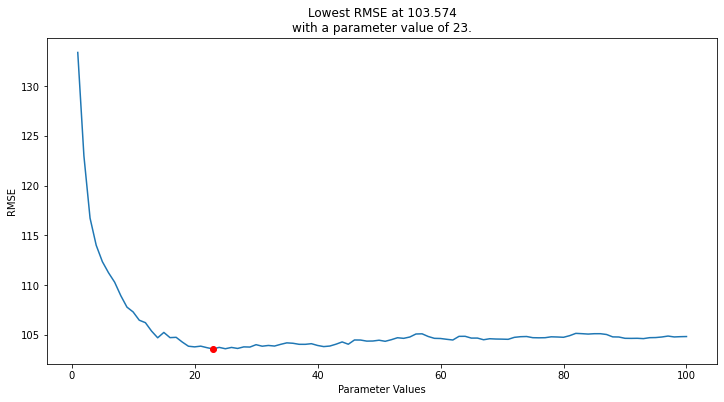

In [12]:
# Create a for loop for the min_samples_leaf parameter.
leaf_values = [i for i in range(1,101)]
leaf_dict = {}

for i in leaf_values:
    dtr = DecisionTreeRegressor(min_samples_leaf=i)
    dtr.fit(train[feature_columns], train['cnt'])
    predictions = dtr.predict(test[feature_columns])
    rmse = (mean_squared_error(test['cnt'], predictions))**0.5
    leaf_dict[i] = rmse

# Create a function to plot and state the optimal count for parameters involved.
def best_number(dict_name):
    values = []
    rmses = []
    for k, v in dict_name.items():
        values.append(k)
        rmses.append(v)
    min_rmse_index = rmses.index(min(rmses))
    min_value = values[min_rmse_index]
    plt.subplots(figsize=(12,6))
    plt.plot(values, rmses)
    plt.plot(min_value, min(rmses), 'ro')
    plt.title(label='Lowest RMSE at {:.3f}\nwith a parameter value of {}.'.format(min(rmses), min_value))
    plt.xlabel('Parameter Values')
    plt.ylabel('RMSE')
    plt.show()
    return min_value

best_leaf = best_number(leaf_dict)

While the ideal min_samples_leaf value is at 23 with an rmse value of 103.574, the values presented hover between 103 to 105 starting from a min_samples_leaf value of 13 onwards. While having a min_samples_leaf is acceptable at 13, let's continue with a value of 23. Note: 'min_samples_leaf' is the minimum amount of values required by the model to create a leaf in the decision tree. So if the 'min_samples_leaf' is set to 23, each leaf in the tree needs to have at least 23 values or rows. This prevents overfitting in the model.

Let's proceed with 'min_samples_split'. This parameter determines the minimum amount of values or rows needed to make a split. If the number of values or rows are lower than the threshold, the said values will be classified as leaves instead. Again, this prevents overfitting in the model.

### Adjust 'min_samples_split' parameter

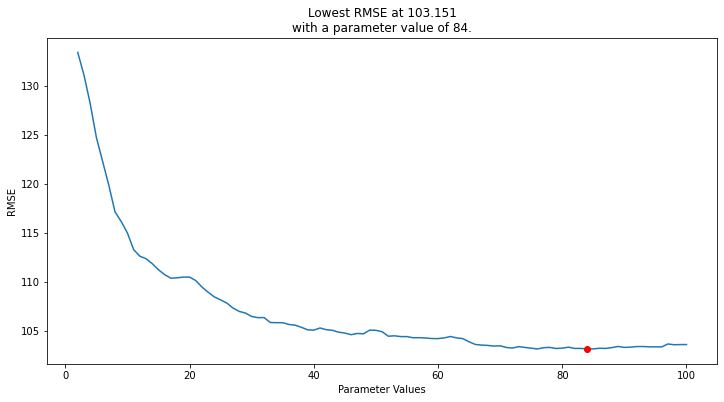

In [13]:
# Create a for loop for the min_samples_split parameter.
split_values = [i for i in range(2,101)]
split_dict = {}

for i in split_values:
    dtr = DecisionTreeRegressor(min_samples_split=i)
    dtr.fit(train[feature_columns], train['cnt'])
    predictions = dtr.predict(test[feature_columns])
    rmse = (mean_squared_error(test['cnt'], predictions))**0.5
    split_dict[i] = rmse

# Use the best_number function to extract the optimal count for min_samples_split.
best_split = best_number(split_dict)

The amount of decrease in rmse gets smaller the higher the inputs for 'min_samples_split'. For this, the lowest value we got is 84 with an rmse of 103.151.

Let's proceed with the final parameter that will be analyzed: 'max_depth'. As the parameter name suggests, this sets the maximum number of depths allowed for the decision tree. Let's set a range of 5 to 15 for this.

### Adjust 'max_depth' parameter

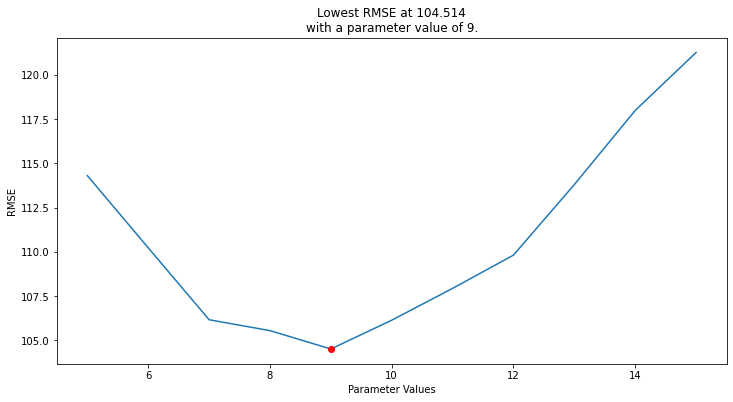

In [14]:
# Create a for loop for the max_depth parameter.
depth_values = [i for i in range(5,16)]
depth_dict = {}

for i in depth_values:
    dtr = DecisionTreeRegressor(max_depth=i)
    dtr.fit(train[feature_columns], train['cnt'])
    predictions = dtr.predict(test[feature_columns])
    rmse = (mean_squared_error(test['cnt'], predictions))**0.5
    depth_dict[i] = rmse

# Use the best_number function to extract the optimal count for min_samples_split.
best_depth = best_number(depth_dict)

The results here follow a U curve, with the value of 9 at the bottom. The rmse value is at 104.513.

If we combine all of the parameters together, is it possible to generate a lower cost function? Let's find out.

### Include all parameter values for Decision Trees Regressor

In [15]:
# Include all of the parameter values conducted in the for loops into one DecisionTreeRegressor.
dtr = DecisionTreeRegressor(min_samples_leaf=23, min_samples_split=84, max_depth=9)
dtr.fit(train[feature_columns], train['cnt'])
train_predictions = dtr.predict(train[feature_columns])
train_rmse = mean_squared_error(train['cnt'], train_predictions, squared=False)
print('Train RMSE: {:.2f}'.format(train_rmse))
test_predictions = dtr.predict(test[feature_columns])
test_rmse = mean_squared_error(test['cnt'], test_predictions, squared=False)
print('Test RMSE: {:.2f}'.format(test_rmse))

Train RMSE: 101.62
Test RMSE: 104.76


While it appears there is no instance of overfitting, combining all of the parameters used is not enough to lower the rmse to a level that can be appreciated. With this, let's proceed with a more complex model: the Random Forest.

The Random Forest model will generate several trees and compile all of the results into one model. This should be able to generate more accurate/lower RMSE results. Since several trees will be generated, it will be possible to include all of the appropriate columns from the dataset to generate different results. This should also reduce overfitting.

## Random Forest Model

In [16]:
# Include all appropriate columns for the Random Forest. We can include columns that have high collinearity since it is possible they will not be used in under one tree.
rfr_columns = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']

# Import RandomForestRegressor.
from sklearn.ensemble import RandomForestRegressor

# Create Random Forest model.
rfr = RandomForestRegressor(random_state=1)
rfr.fit(train[rfr_columns], train['cnt'])
train_predictions = rfr.predict(train[rfr_columns])
train_rmse = (mean_squared_error(train['cnt'], train_predictions))**0.5
print(train_rmse)
test_predictions = rfr.predict(test[rfr_columns])
test_rmse = (mean_squared_error(test['cnt'], test_predictions))**0.5
print(test_rmse)

15.895826268783399
44.310634484224785


While the results are better than the Decision Tree Regressor, it is important to point out the the current result shows that the model is overfitting. The 'train_rmse' has a distant value compared to 'test_rmse'. In this case, it is recommended to find ways to reduce overfitting and also attempt to reduce the train rmse.

Let's consider tweaking the parameters and modify the 'n_estimators' which is the number of trees the function will produce. The default value is at 100.

### Adjust 'n_estimators' parameter

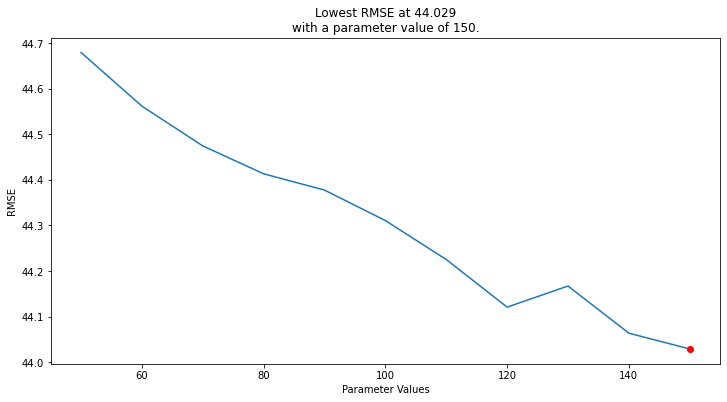

In [17]:
# Generate values from 50 to 150, with increments of 10 between values.
est_values = [i for i in range(50, 160, 10)]
est_dict = {}

for i in est_values:
    rfr = RandomForestRegressor(random_state=1, n_estimators=i)
    rfr.fit(train[rfr_columns], train['cnt'])
    predictions = rfr.predict(test[rfr_columns])
    rmse = (mean_squared_error(test['cnt'], predictions))**0.5
    est_dict[i] = rmse

best_est = best_number(est_dict)

No significant change seen in values. Let's tweak another parameter: 'max_samples'. 'max_samples' Indicates the number of samples needed by the function to generate a single tree.

### Adjust 'max_samples' parameter

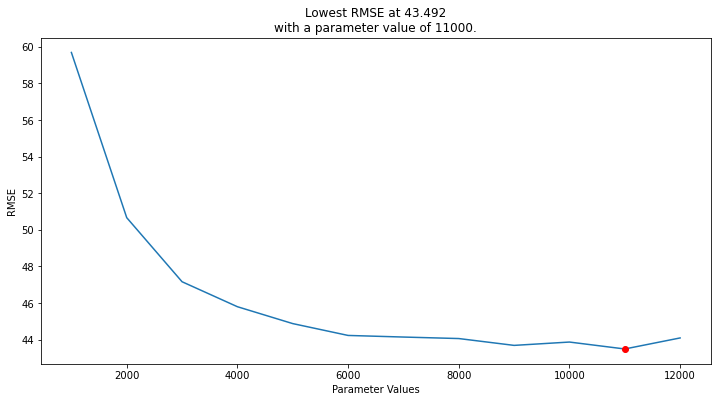

In [18]:
# Generate values for 'max_samples' from 1,000 until 12,000 with a step of 1,000.
samples_values = [i for i in range(1000, 13000, 1000)]
samples_dict = {}

for i in samples_values:
    rfr = RandomForestRegressor(random_state=1, max_samples=i)
    rfr.fit(train[rfr_columns], train['cnt'])
    predictions = rfr.predict(test[rfr_columns])
    rmse = (mean_squared_error(test['cnt'], predictions))**0.5
    samples_dict[i] = rmse

best_samples = best_number(samples_dict)

Ideal 'max_samples' value at 11000 samples. While the rmse was reduced, the results are still similar to the random forest with default values. Let's try to use the 'min_samples_leaf' parameter.

### Adjust 'min_samples_leaf' parameter

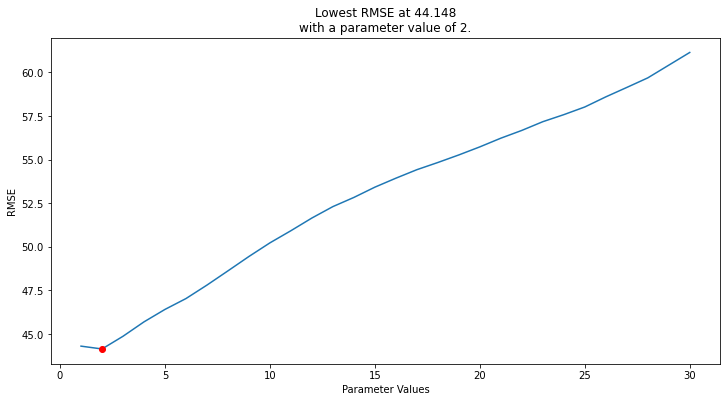

In [19]:
# Generate values for the 'min_samples_leaf' from 1 to 30.
leaves_values = [i for i in range(1, 31)]
leaves_dict = {}

for i in leaves_values:
    rfr = RandomForestRegressor(random_state=1, min_samples_leaf=i)
    rfr.fit(train[rfr_columns], train['cnt'])
    predictions = rfr.predict(test[rfr_columns])
    rmse = (mean_squared_error(test['cnt'], predictions))**0.5
    leaves_dict[i] = rmse

best_leaves = best_number(leaves_dict)

The 'min_samples_leaf' parameter returned a best value of 2.

We can input all of the results we have generated for the Random Trees Regressor and see if there is an improvement with the scores.

### Include all parameter values for Random Trees Regressor

In [20]:
# Input all of the best results generated per parameter for the Random Trees Regressor.
rfr = RandomForestRegressor(random_state=1, n_estimators=150, max_samples=11000, min_samples_leaf=2)
rfr.fit(train[rfr_columns], train['cnt'])
train_predictions = rfr.predict(train[rfr_columns])
train_rmse = mean_squared_error(train_predictions, train['cnt'], squared=False)
test_predictions = rfr.predict(test[rfr_columns])
test_rmse = mean_squared_error(test_predictions, test['cnt'], squared=False)
print('Train RMSE: {:.2f}'.format(train_rmse))
print('Test RMSE: {:.2f}'.format(test_rmse))

Train RMSE: 24.72
Test RMSE: 43.81


No significant improvements with rmse, but the overfitting issue has been improved.

While we received the best parameter values, it appears that the results are similar to the first result where none of the default parameters were changed. What improved is the overfitting issue since the Train RMSE and Test RMSE values are now closer to each other.

While the overfitting issues improved, it still needs to be reduced.

### Notes on Parameters Optimization

It is possible to use parameter optimizers on sklearn such as GridSearchCV, but this will take significant time to complete the process. Given this constraint, it is recommended to use HalvingRandomSearchCV instead. This should be more efficient than GridSearchCV.

In [21]:
from sklearn.model_selection import RandomizedSearchCV

rfr = RandomForestRegressor()
parameters = {
    'random_state':[1],
    'n_estimators':[500,1000,1500],
    'max_depth':[15,20,25],
    'min_samples_split':[15,20,25],
    'min_samples_leaf':[5,10]
}
rsc = RandomizedSearchCV(estimator=rfr, param_distributions=parameters, n_iter=5)
rsc.fit(train[rfr_columns], train['cnt'])
print('Best Parameters: {}'.format(rsc.best_params_))

Best Parameters: {'random_state': 1, 'n_estimators': 1500, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_depth': 25}


In [22]:
# Let's plug in the best parameters to the RandomForestRegressor.
rfr = RandomForestRegressor(random_state=1, n_estimators=1500, max_depth=20, min_samples_split=20, min_samples_leaf=10)
rfr.fit(train[rfr_columns], train['cnt'])
train_predictions = rfr.predict(train[rfr_columns])
train_rmse = (mean_squared_error(train['cnt'], train_predictions))**0.5
print('Train RMSE: {:.2f}'.format(train_rmse))
test_predictions = rfr.predict(test[rfr_columns])
test_rmse = (mean_squared_error(test['cnt'], test_predictions))**0.5
print('Test RMSE: {:.2f}'.format(test_rmse))

Train RMSE: 41.82
Test RMSE: 50.09


### Final Results

The Test RMSE from the Random Forest Regressor generated a higher RMSE than the first Random Forest output. The last Test RMSE should be the recommended output since it has less chances of overfitting when compared to the first output.

## Notes on RMSE and MAE
On the other hand, rmse is used to generate error value from the models. For actual use, mae can be utilized to see the actual errors seen from the analysis.

The rmse was used heavily in this analysis because it amplifies the errors generated by the models. This gives indication how big the errors are from the models. With this, we can use mae to see the actual average error.

## Determine Mean Absolute Error for the Random Forest Model

In [23]:
# Import mean_absolute_error
from sklearn.metrics import mean_absolute_error

# Use mae to generate actual error value with max_samples of 11000.
mae = mean_absolute_error(test['cnt'], predictions)
print('Test MAE: {:.2f}'.format(mae))

Test MAE: 38.47


## Conclusion
The lowest rmse value of 50.09 and mae value of 38.47 are generated for this analysis. There are several ways to improve this analysis:

1. Separate the late evening to early morning to isolate the times where there are higher demands during the day.
2. Instead of predicting the total count of bicycles rented, it might help to individually predict the value for 'casual' and 'registered'. What might happen here is that there are features that might have higher correlation for each individual category.